# **Modèles pour classification textuelles**

Une fois les données nettoyées dans le notebook `1. Preprocessing` précédent, nous allons maintenant utiliser plusieurs modèles pour tenter de modéliser

# 1. Avant propos et méthodologie

## 1.1 Premiers éléments

Nous allons faire de la classification textuelle avec _overlapping_ de labels.
Les labels sont équilibrés, à priori pas besoin d'utiliser les méthodes spécifiques au _imbalanced dataset_

## 1.2 Modèles utilisés

Afin de réaliser l'exercice en un temps raisonnable je me suis limité à prendre les modèles "sur étagère" largement connus et utilisés par la communauté plutôt que des algorithmes plus pointus adaptés à cette tâche spécifique.

Les modèles classique ,classés par "ordre de complexité" sont les suivants :
- (Non implémenté) Bag of Words
- TF-IDF
- Embedding statique _a la_ word2vec
- (Non implémenté) Combinaison des deux méthodes pour faire du doc/sent2vec où les pondérations par mot sont données par le TF-IDF
- Embedding "dynamique" en ayant recours à un transformers, ici camembert (BERT français)

Pour comparer les modèles, une fois obtenue la représentation vectorielle de la phrase, une simple régression logisitique est appliquée en sortie.

# 2. Packages usuels et importation

In [1]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Packages classiques
import pandas as pd
import numpy as np
import torch

# Custom package
import func_custom as fc

# NLP
import spacy
import spacy_transformers
from transformers import CamembertModel, CamembertTokenizer

# Machine Learning
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
df_train = pd.read_csv("data/data_clean.csv",
                       sep = ";")

In [4]:
df_train["label_1"] = df_train["label"].apply(lambda x : "1" in x)
df_train["label_8"] = df_train["label"].apply(lambda x : "8" in x)

In [17]:
# Transformer en une liste
documents = df_train["message_clean"].tolist()
labels = df_train["label_1"].tolist()

# 3. Différents modèles implémentés

## 3.1 TF_IDF

L'approche "Bag of Word" (un one hot encoder des mots du vocabulaire) n'est pas montrée car le TF_IDF est une amélioration immédiation où au lieu d'avoir des simples 1 dans la matrice, les poids de chaque mots dans la phrase sont pondérés par un critère d'importance. La taille de la matrice reste cependnat la même.

In [18]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
X = vectorizer.fit_transform(documents)

In [19]:
X

<700x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 27028 stored elements in Compressed Sparse Row format>

In [20]:
df_train

,label,message,message_clean,label_1,label_8
0,8,"Madame,Monsieur, je me permet de vous envoyer ...",permet envoyer courriel viens apercevoir alloc...,False,True
1,8,je désire connaitre quel est le montant de mo...,désire connaitre quel montant impot revenu con...,False,True
2,8,"Bonjour, Je fais suite du dernier message envo...",fais suite dernier message envoyé concernant n...,False,True
3,8,"Bonjour, Je me permets de vous contacter afin ...",permets contacter afin obtenir réponse déclara...,False,True
4,8,"Madame, Monsieur, Après avoir déclaré nos r...",après déclaré revenus pacs signé constatons ta...,False,True
...,...,...,...,...,...
695,8,"Bonjour, Depuis que j'ai déclaré mon PACS av...",depuis déclaré pacs retraites baissé pourquoi ...,False,True
696,8,"Bonjour, Je voudrais opter pour le taux de pre...",voudrais opter taux prélèvement individualisé ...,False,True
697,1,Bonjour Madame Monsieur Je signale un changeme...,signale changement situation familiale depuis ...,True,False
698,8,"Bonjour, Je dois déclarer un changement de si...",dois déclarer changement situation famille pac...,False,True


In [15]:
# Step 3: Train a classifier
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)

# Step 4: Evaluate your model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [16]:
print(report)

              precision    recall  f1-score   support

       False       0.78      0.74      0.76        98
        True       0.79      0.82      0.80       112

    accuracy                           0.79       210
   macro avg       0.79      0.78      0.78       210
weighted avg       0.79      0.79      0.79       210



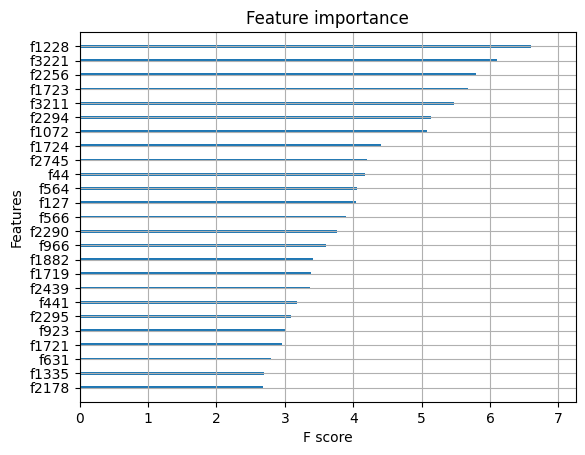

In [63]:
_ = xgb.plot_importance(classifier, 
                        importance_type = "gain",
                        max_num_features = 25,
                        show_values = False)

## 3.2 Word2vec et donc Doc2vec

In [74]:
from gensim.models import Word2Vec


word2vec_model = Word2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

def get_document_vector(doc, model):
    valid_words = [word for word in doc if word in model.wv.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

In [75]:
df_train

,label,message,message_clean,label_1,label_8
0,8,"Madame,Monsieur, je me permet de vous envoyer ...",madam monsieur permet envoi courriel car vien ...,False,True
1,8,je désire connaitre quel est le montant de mo...,désir connaitr quel mont impot revenu concern...,False,True
2,8,"Bonjour, Je fais suite du dernier message envo...",bonjour fais suit derni messag envoyé concern...,False,True
3,8,"Bonjour, Je me permets de vous contacter afin ...",bonjour permet contact afin obten répons déc...,False,True
4,8,"Madame, Monsieur, Après avoir déclaré nos r...",madam monsieur aprè avoir déclaré revenus m...,False,True
...,...,...,...,...,...
695,8,"Bonjour, Depuis que j'ai déclaré mon PACS av...",bonjour depuis déclaré pac mr retrait baisse...,False,True
696,8,"Bonjour, Je voudrais opter pour le taux de pre...",bonjour voudr opter taux prélèv individualis...,False,True
697,1,Bonjour Madame Monsieur Je signale un changeme...,bonjour madam monsieur signal chang situat fam...,True,False
698,8,"Bonjour, Je dois déclarer un changement de si...",bonjour dois déclar chang situat famill pac c...,False,True


In [76]:
df_train['doc_vector'] = df_train['message_clean'].apply(lambda x: get_document_vector(x, word2vec_model))

# Prepare feature and target variables
X = np.vstack(df_train['doc_vector'].values)
y = df_train['label_1']

In [79]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5


c:\Users\TitouanBlaize\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TitouanBlaize\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TitouanBlaize\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
X.shape

(700, 100)

In [80]:
print(report)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        70
        True       0.50      1.00      0.67        70

    accuracy                           0.50       140
   macro avg       0.25      0.50      0.33       140
weighted avg       0.25      0.50      0.33       140



## 3.3 Transformers : Camembert (RoBERTa)

On utilise Camembert directement. On aurait également pu passer par Spacy qui dispose d'un transformers français https://spacy.io/models/fr#fr_dep_news_trf

In [6]:
# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-base-wikipedia-4gb")
camembert = CamembertModel.from_pretrained("camembert/camembert-base-wikipedia-4gb")

c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [44]:
df_camembert  = pd.DataFrame()
for index, row in df_train.iterrows():
    message_raw = row["message"]

    tokenized_sentence = tokenizer.tokenize(message_raw)

    encoded_sentence = tokenizer.encode(tokenized_sentence)

    if (len(encoded_sentence) > 512) :
        encoded_sentence = encoded_sentence[:511]
        
    encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)

    results_camembert = camembert(encoded_sentence)

    new_row = pd.DataFrame(results_camembert.last_hidden_state.detach()[:,0,:])
    df_camembert = pd.concat([df_camembert, new_row], ignore_index = True)

df_camembert.to_csv("data/data_camembert.csv", sep = ";", index = False)

In [66]:
y = df_train["label_8"]
X = df_camembert

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7928571428571428


c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
print(report)

              precision    recall  f1-score   support

       False       0.78      0.74      0.76        61
        True       0.80      0.84      0.82        79

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.79       140
weighted avg       0.79      0.79      0.79       140

